## Evaluate Presidio Analyzer using the Presidio Evaluator framework

This notebook demonstrates how to evaluate a Presidio instance using the presidio-evaluator framework
Steps:
1. Load dataset from file
2. Simple dataset statistics
3. Define the AnalyzerEngine object (and its parameters)
4. Align the dataset's entities to Presidio's entities
5. Set up the Evaluator object
6. Run experiment
7. Evaluate results
8. Error analysis

For an example with a custom Presidio instance, see [notebook 5](5_Evaluate_Custom_Presidio_Analyzer.ipynb).

In [1]:
# install presidio evaluator via pip if not yet installed

#!pip install presidio-evaluator

In [2]:
from pathlib import Path
from pprint import pprint
from collections import Counter
from typing import Dict, List
import json

from presidio_evaluator import InputSample
from presidio_evaluator.evaluation import Evaluator, ModelError, Plotter
from presidio_evaluator.experiment_tracking import get_experiment_tracker

import pandas as pd

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

%reload_ext autoreload
%autoreload 2
%matplotlib inline

## 1. Load dataset from file

In [3]:
dataset_name = "synth_dataset_v2.json"
dataset = InputSample.read_dataset_json(Path(Path.cwd().parent, "data", dataset_name))
print(len(dataset))

tokenizing input:   0%|          | 0/1500 [00:00<?, ?it/s]

loading model en_core_web_sm


tokenizing input: 100%|██████████| 1500/1500 [00:07<00:00, 192.66it/s]

1500


This dataset was auto generated. See more info here [Synthetic data generation](1_Generate_data.ipynb).

In [4]:
def get_entity_counts(dataset: List[InputSample]) -> Dict:
    """Return a dictionary with counter per entity type."""
    entity_counter = Counter()
    for sample in dataset:
        for tag in sample.tags:
            entity_counter[tag] += 1
    return entity_counter


## 2. Simple dataset statistics

In [5]:
entity_counts = get_entity_counts(dataset)
print("Count per entity:")
pprint(entity_counts.most_common(), compact=True)

print("\nMin and max number of tokens in dataset: "\
f"Min: {min([len(sample.tokens) for sample in dataset])}, "\
f"Max: {max([len(sample.tokens) for sample in dataset])}")

print(f"Min and max sentence length in dataset: " \
f"Min: {min([len(sample.full_text) for sample in dataset])}, "\
f"Max: {max([len(sample.full_text) for sample in dataset])}")

print("\nExample InputSample:")
print(dataset[0])

Count per entity:
[('O', 19626), ('STREET_ADDRESS', 3071), ('PERSON', 1369), ('GPE', 521),
 ('ORGANIZATION', 504), ('PHONE_NUMBER', 350), ('DATE_TIME', 219),
 ('TITLE', 142), ('CREDIT_CARD', 136), ('US_SSN', 80), ('AGE', 74), ('NRP', 55),
 ('ZIP_CODE', 50), ('EMAIL_ADDRESS', 49), ('DOMAIN_NAME', 37),
 ('IP_ADDRESS', 22), ('IBAN_CODE', 21), ('US_DRIVER_LICENSE', 9)]

Min and max number of tokens in dataset: Min: 3, Max: 78
Min and max sentence length in dataset: Min: 9, Max: 407

Example InputSample:
Full text: The address of Persint is 6750 Koskikatu 25 Apt. 864
Artilleros
, CO
 Uruguay 64677
Spans: [Span(type: STREET_ADDRESS, value: 6750 Koskikatu 25 Apt. 864
Artilleros
, CO
 Uruguay 64677, char_span: [26: 83]), Span(type: ORGANIZATION, value: Persint, char_span: [15: 22])]



In [6]:
print("A few examples sentences containing each entity:\n")
for entity in entity_counts.keys():
    samples = [sample for sample in dataset if entity in set(sample.tags)]
    if len(samples) > 1 and entity != "O":
        print(f"Entity: <{entity}> two example sentences:\n"
              f"\n1) {samples[0].full_text}"
              f"\n2) {samples[1].full_text}"
              f"\n------------------------------------\n")

A few examples sentences containing each entity:

Entity: <ORGANIZATION> two example sentences:

1) The address of Persint is 6750 Koskikatu 25 Apt. 864
Artilleros
, CO
 Uruguay 64677
2) The Exversion Orchestra was founded in 1977. Since then, it has grown from a volunteer community orchestra to a fully professional orchestra serving Southern Tunisia
------------------------------------

Entity: <STREET_ADDRESS> two example sentences:

1) The address of Persint is 6750 Koskikatu 25 Apt. 864
Artilleros
, CO
 Uruguay 64677
2) Billing address: Sara Schwarz
    28245 Puruntie 82 Apt. 595
   LAPPEENRANTA
    SK
    53650
------------------------------------

Entity: <PERSON> two example sentences:

1) Krisztián Szöllösy listed his top 20 songs for Entertainment Weekly and had the balls to list this song at #15. (What did he put at #1 you ask? Answer:"Tube Snake Boogie" by Szabina J Gelencsér ג€“ go figure)
2) My name is Rubija
------------------------------------

Entity: <DATE_TIME> two ex

## 3. Define the AnalyzerEngine object 
Using Presidio with default parameters (not recommended, it's used here for simplicity). For an example on customization, see [notebook 5](5_Evaluate_Custom_Presidio_Analyzer.ipynb)

In [7]:
from presidio_analyzer import AnalyzerEngine
# Loading the vanilla Analyzer Engine, with the default NER model.
analyzer_engine = AnalyzerEngine(default_score_threshold=0.4)

pprint(f"Supported entities for English:")
pprint(analyzer_engine.get_supported_entities("en"), compact=True)

print(f"\nLoaded recognizers for English:")
pprint([rec.name for rec in analyzer_engine.registry.get_recognizers("en", all_fields=True)], compact=True)

print(f"\nLoaded NER models:")
pprint(analyzer_engine.nlp_engine.models)

'Supported entities for English:'
['IN_VEHICLE_REGISTRATION', 'IN_PAN', 'PHONE_NUMBER', 'US_BANK_NUMBER',
 'US_SSN', 'DATE_TIME', 'IN_VOTER', 'NRP', 'CRYPTO', 'LOCATION', 'US_PASSPORT',
 'US_ITIN', 'IN_AADHAAR', 'EMAIL_ADDRESS', 'SG_NRIC_FIN', 'AU_ACN',
 'ORGANIZATION', 'AU_ABN', 'AU_MEDICARE', 'UK_NHS', 'PERSON', 'MEDICAL_LICENSE',
 'URL', 'CREDIT_CARD', 'IBAN_CODE', 'IN_PASSPORT', 'US_DRIVER_LICENSE',
 'IP_ADDRESS', 'AU_TFN']

Loaded recognizers for English:
['CreditCardRecognizer', 'UsBankRecognizer', 'UsLicenseRecognizer',
 'UsItinRecognizer', 'UsPassportRecognizer', 'UsSsnRecognizer', 'NhsRecognizer',
 'SgFinRecognizer', 'AuAbnRecognizer', 'AuAcnRecognizer', 'AuTfnRecognizer',
 'AuMedicareRecognizer', 'InPanRecognizer', 'InAadhaarRecognizer',
 'InVehicleRegistrationRecognizer', 'InPassportRecognizer', 'CryptoRecognizer',
 'DateRecognizer', 'EmailRecognizer', 'IbanRecognizer', 'IpRecognizer',
 'MedicalLicenseRecognizer', 'PhoneRecognizer', 'UrlRecognizer',
 'InVoterRecognizer', 'Sp

## 4. Align the dataset's entities to Presidio's entities

There is possibly a difference between the names of entities in the dataset, and the names of entities Presidio can detect.
For example, it could be that a dataset labels a name as PER while Presidio returns PERSON. To be able to compare the predicted value to the actual and gather metrics, an alignment between the entity names is necessary. Consider changing the mapping if your dataset and/or Presidio instance supports difference entity types.

In [8]:
from presidio_evaluator.models import  PresidioAnalyzerWrapper

entities_mapping=PresidioAnalyzerWrapper.presidio_entities_map # default mapping

print("Using this mapping between the dataset and Presidio's entities:")
pprint(entities_mapping, compact=True)


dataset = Evaluator.align_entity_types(
    dataset, 
    entities_mapping=entities_mapping, 
    allow_missing_mappings=True
)
new_entity_counts = get_entity_counts(dataset)
print("\nCount per entity after alignment:")
pprint(new_entity_counts.most_common(), compact=True)

dataset_entities = list(new_entity_counts.values())


Using this mapping between the dataset and Presidio's entities:
{'ADDRESS': 'LOCATION',
 'AGE': 'AGE',
 'BIRTHDAY': 'DATE_TIME',
 'CITY': 'LOCATION',
 'CREDIT_CARD': 'CREDIT_CARD',
 'DATE': 'DATE_TIME',
 'DATE_OF_BIRTH': 'DATE_TIME',
 'DATE_TIME': 'DATE_TIME',
 'DOB': 'DATE_TIME',
 'DOMAIN': 'URL',
 'DOMAIN_NAME': 'URL',
 'EMAIL': 'EMAIL_ADDRESS',
 'EMAIL_ADDRESS': 'EMAIL_ADDRESS',
 'FACILITY': 'LOCATION',
 'FIRST_NAME': 'PERSON',
 'GPE': 'LOCATION',
 'HCW': 'PERSON',
 'HOSP': 'ORGANIZATION',
 'HOSPITAL': 'ORGANIZATION',
 'IBAN': 'IBAN_CODE',
 'IBAN_CODE': 'IBAN_CODE',
 'ID': 'ID',
 'IP_ADDRESS': 'IP_ADDRESS',
 'LAST_NAME': 'PERSON',
 'LOC': 'LOCATION',
 'LOCATION': 'LOCATION',
 'NATIONALITY': 'NRP',
 'NORP': 'NRP',
 'NRP': 'NRP',
 'O': 'O',
 'ORG': 'ORGANIZATION',
 'ORGANIZATION': 'ORGANIZATION',
 'PATIENT': 'PERSON',
 'PATORG': 'ORGANIZATION',
 'PER': 'PERSON',
 'PERSON': 'PERSON',
 'PHONE': 'PHONE_NUMBER',
 'PHONE_NUMBER': 'PHONE_NUMBER',
 'PREFIX': 'TITLE',
 'SSN': 'US_SSN',
 'STAF

## 5. Set up the Evaluator object

In [9]:
# Set up the experiment tracker to log the experiment for reproducibility
experiment = get_experiment_tracker()

# Create the evaluator object
evaluator = Evaluator(model=analyzer_engine)


# Track model and dataset params
params = {"dataset_name": dataset_name, 
          "model_name": evaluator.model.name}
params.update(evaluator.model.to_log())
experiment.log_parameters(params)
experiment.log_dataset_hash(dataset)
experiment.log_parameter("entity_mappings", json.dumps(entities_mapping))

--------
Entities supported by this Presidio Analyzer instance:
IN_VEHICLE_REGISTRATION, IN_PAN, PHONE_NUMBER, US_BANK_NUMBER, US_SSN, DATE_TIME, IN_VOTER, NRP, CRYPTO, LOCATION, US_PASSPORT, US_ITIN, IN_AADHAAR, EMAIL_ADDRESS, SG_NRIC_FIN, AU_ACN, ORGANIZATION, AU_ABN, AU_MEDICARE, UK_NHS, PERSON, MEDICAL_LICENSE, URL, CREDIT_CARD, IBAN_CODE, IN_PASSPORT, US_DRIVER_LICENSE, IP_ADDRESS, AU_TFN


## 6. Run experiment

In [10]:
%%time

## Run experiment

evaluation_results = evaluator.evaluate_all(dataset)
results = evaluator.calculate_score(evaluation_results)

# Track experiment results
experiment.log_metrics(results.to_log())
entities, confmatrix = results.to_confusion_matrix()
experiment.log_confusion_matrix(matrix=confmatrix, 
                                labels=entities)

# end experiment
experiment.end()

Running model PresidioAnalyzerWrapper on dataset...
Finished running model on dataset
saving experiment data to experiment_20241130-125430.json
CPU times: user 5.57 s, sys: 189 ms, total: 5.76 s
Wall time: 5.99 s


## 7. Evaluate results

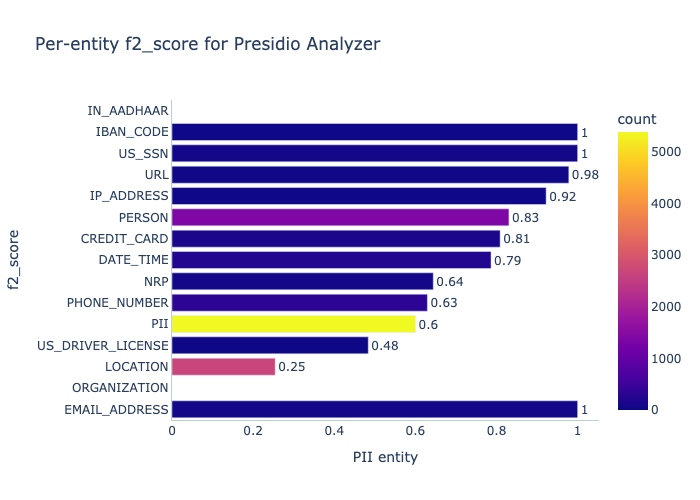

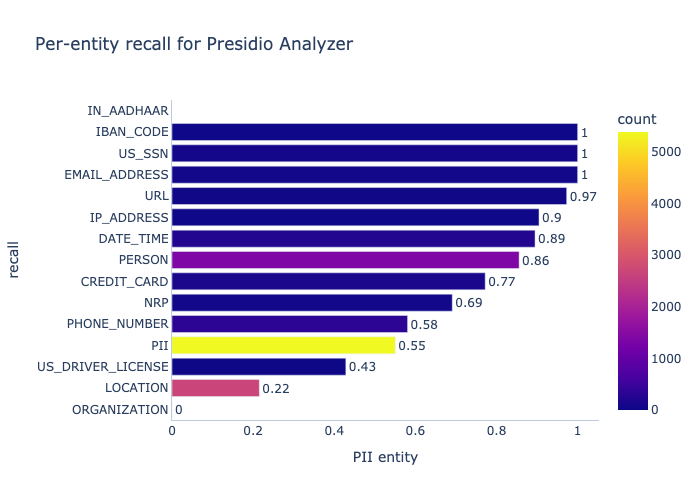

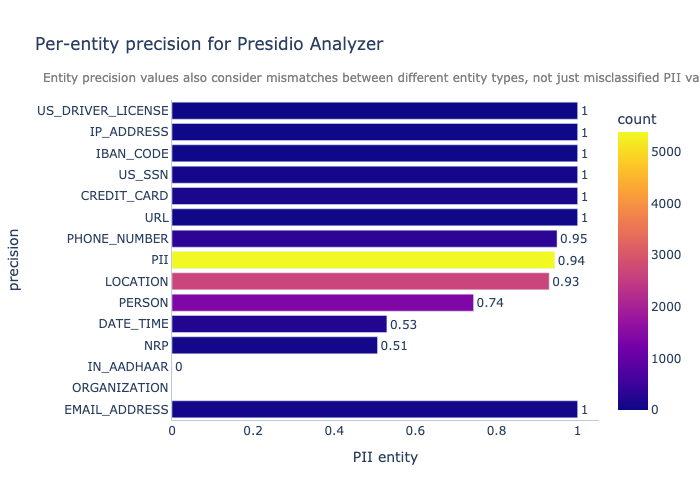

In [11]:
# Plot output
plotter = Plotter(results=results, 
                  output_folder = "plots",
                  model_name = evaluator.model.name, 
                  #save_as="png",
                  beta = 2)


plotter.plot_scores()

In [12]:
pprint({"PII F":results.pii_f, "PII recall": results.pii_recall, "PII precision": results.pii_precision})

{'PII F': 0.6004782749675746,
 'PII precision': 0.9436305732484076,
 'PII recall': 0.5504365595392904}


## 8. Error analysis

Now let's look into results to understand what's behind the metrics we're getting.
Note that evaluation is never perfect. Some things to consider:
1. There's often a mismatch between the annotated span and the predicted span, which isn't necessarily a mistake. For example: `<Southern France>` compared with `Southern <France>`. In the second text, the word `Southern` was not annotated/predicted as part of the entity, but that's not necessarily an error.
2. Token based evaluation (which is used here) counts the number of true positive / false positive / false negative tokens. Some entities might be broken into more tokens than others. For example, the phone number `222-444-1234` could be broken into five different tokens, whereas `Krishna` would be broken into one token, resulting in phone numbers having more influence on metrics than names.
3. The synthetic dataset used here isn't representative of a real dataset. Consider using more realistic datasets for evaluation

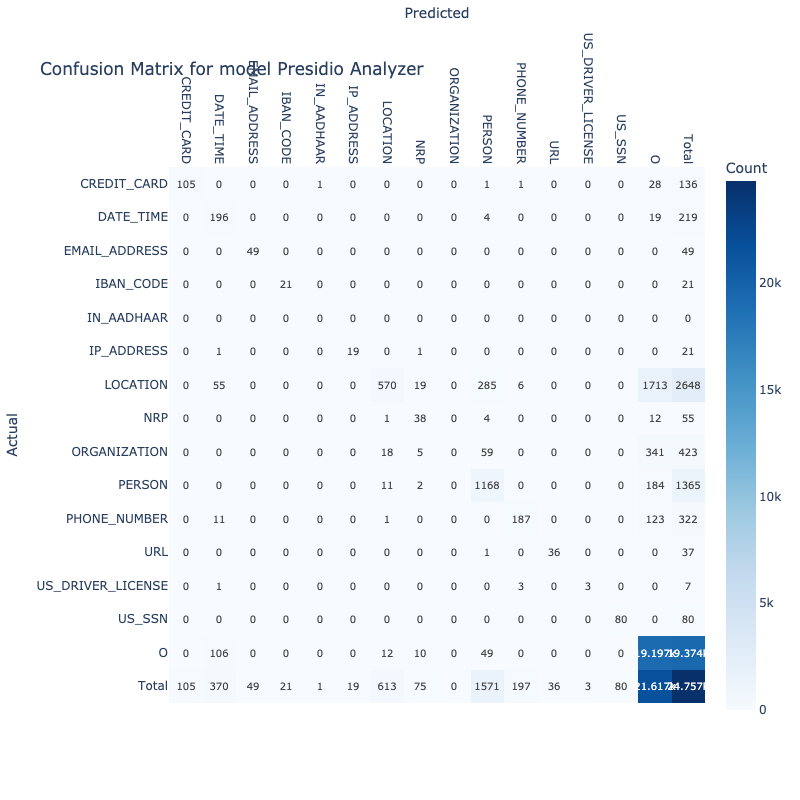

In [13]:
plotter.plot_confusion_matrix(entities=entities, confmatrix=confmatrix)

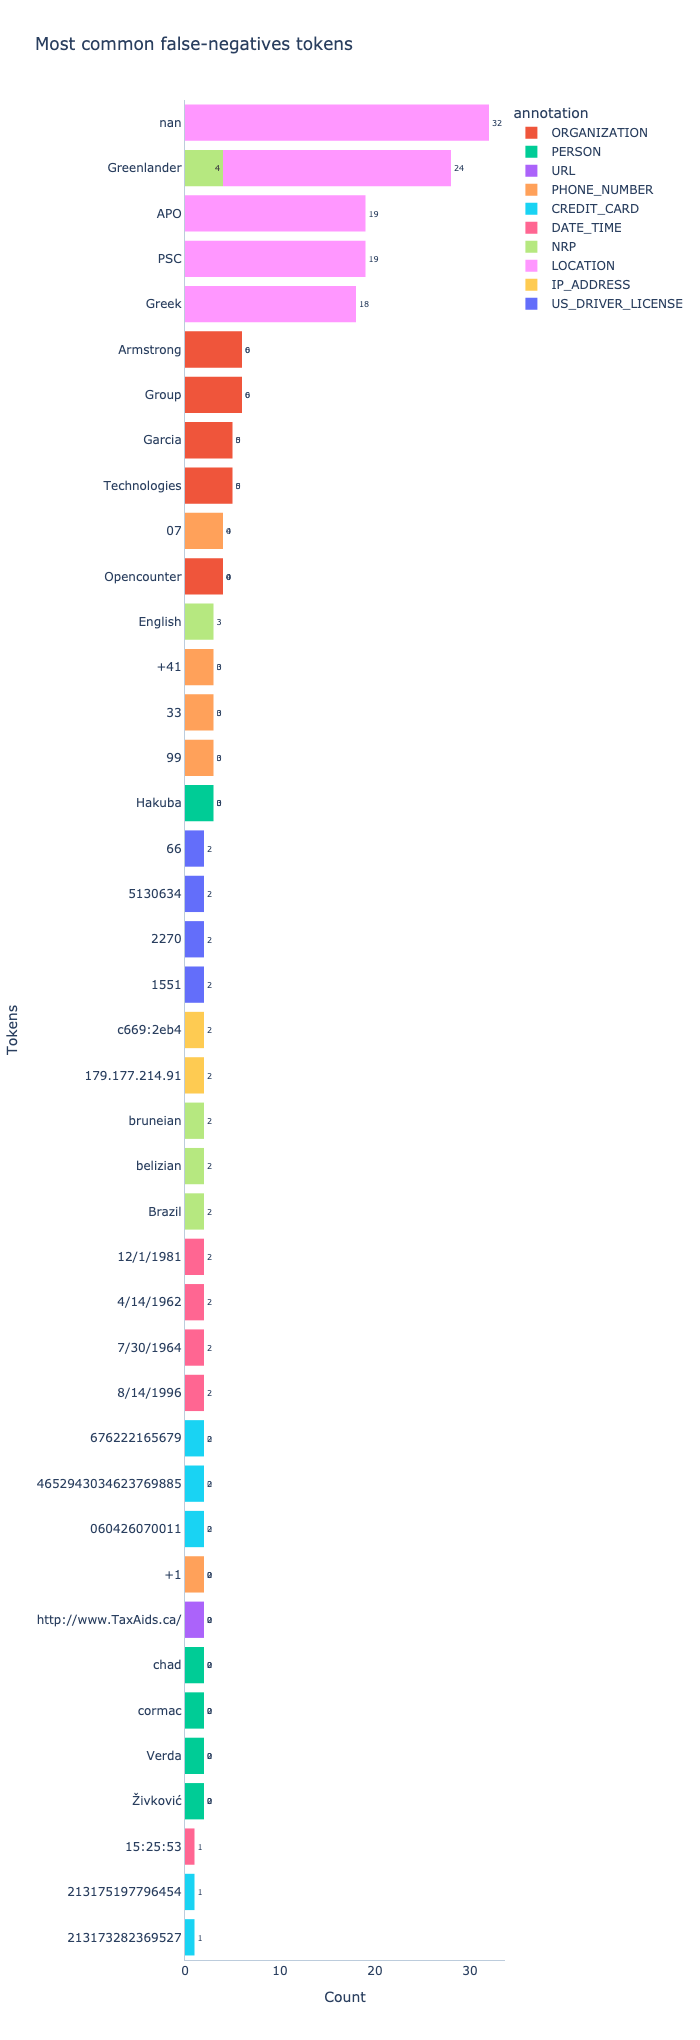

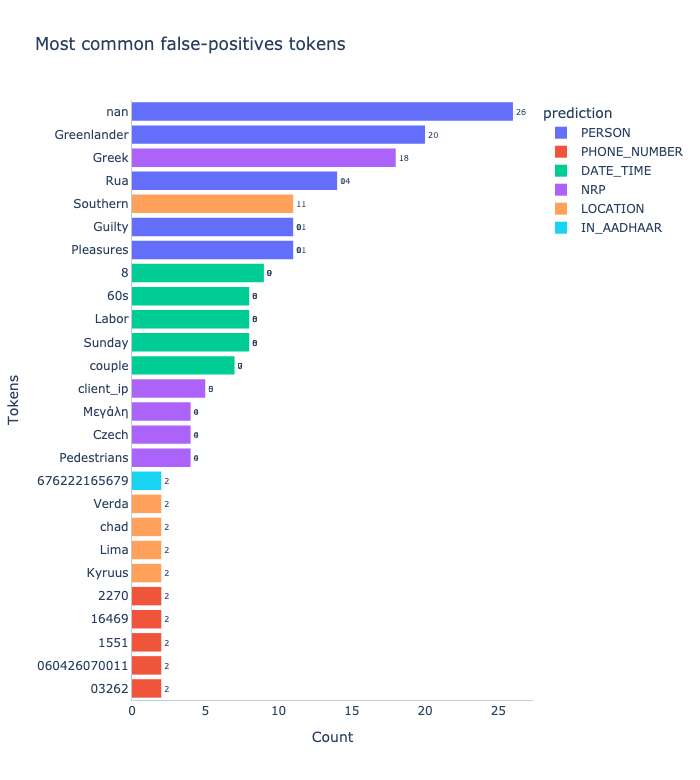

In [14]:
plotter.plot_most_common_tokens()

### 7a. False positives
#### Most common false positive tokens:

In [15]:
ModelError.most_common_fp_tokens(results.model_errors)

Most common false positive tokens:
[('nan', 13),
 ('Southern', 12),
 ('Guilty', 11),
 ('Pleasures', 11),
 ('Greenlander', 10),
 ('8', 9),
 ('Greek', 9),
 ('60s', 8),
 ('Sunday', 8),
 ('Labor', 8)]
---------------
Example sentence with each FP token:
	- Please update the billing address with 27534 Þorsteinsgata 63
MOSS
, nan
 51971 for this card: 4119268469462942 (`nan` pred as PERSON)
	- The Exversion Orchestra was founded in 1977. Since then, it has grown from a volunteer community orchestra to a fully professional orchestra serving Southern Tunisia (`Southern` pred as LOCATION)
	- For my take on Mrs. Labrie, see Guilty Pleasures: 5 Musicians Of The 70s You're Supposed To Hate (But Secretly Love) (`Guilty` pred as PERSON)
	- For my take on Mrs. Labrie, see Guilty Pleasures: 5 Musicians Of The 70s You're Supposed To Hate (But Secretly Love) (`Pleasures` pred as PERSON)
	- Satu Elomo

45818 P.O. Box 242
 Suite 787
 Kangerlussuaq

 Greenlander 54005 (`Greenlander` pred as PERSON)
	- Ener

[('nan', 13),
 ('Southern', 12),
 ('Guilty', 11),
 ('Pleasures', 11),
 ('Greenlander', 10),
 ('8', 9),
 ('Greek', 9),
 ('60s', 8),
 ('Sunday', 8),
 ('Labor', 8)]

#### More FP analysis

In [16]:
fps_df = ModelError.get_fps_dataframe(results.model_errors, entity=["PERSON"])
fps_df[["full_text", "token", "annotation", "prediction"]].head(20)

,full_text,token,annotation,prediction
0,"Krisztián Szöllösy listed his top 20 songs for Entertainment Weekly and had the balls to list this song at #15. (What did he put at #1 you ask? Answer:""Tube Snake Boogie"" by Szabina J Gelencsér ג€“ go figure)","Answer:""Tube",O,PERSON
1,Janka M. Szász\n\nNetwork and computer systems administrator\n\nPersonal Info:\nPhone:\n60-56-85-91\n\nE-mail:\nSzaszJanka@cuvox.de\n\nWebsite:\nhttps://www.UEarly.se/\n\nAddress:\nBrucker Bundesstrasse 31 Zezig Streets\n Suite 245\n FÜRLING\n Austria 25173.,Network,O,PERSON
2,"James Talbot listed his top 20 songs for Entertainment Weekly and had the balls to list this song at #15. (What did he put at #1 you ask? Answer:""Tube Snake Boogie"" by Natalie Åberg ג€“ go figure)","Answer:""Tube",O,PERSON
3,"For my take on Mrs. Labrie, see Guilty Pleasures: 5 Musicians Of The 70s You're Supposed To Hate (But Secretly Love)",Guilty,O,PERSON
4,"For my take on Mrs. Labrie, see Guilty Pleasures: 5 Musicians Of The 70s You're Supposed To Hate (But Secretly Love)",Pleasures,O,PERSON
5,"For my take on Mrs. Lennox, see Guilty Pleasures: 5 Musicians Of The 70s You're Supposed To Hate (But Secretly Love)",Guilty,O,PERSON
6,"For my take on Mrs. Lennox, see Guilty Pleasures: 5 Musicians Of The 70s You're Supposed To Hate (But Secretly Love)",Pleasures,O,PERSON
7,"My religion does not allow speaking to bots, they are evil and hacked by the Devil",Devil,O,PERSON
8,"For my take on Mrs. Baker, see Guilty Pleasures: 5 Musicians Of The 70s You're Supposed To Hate (But Secretly Love)",Guilty,O,PERSON
9,"For my take on Mrs. Baker, see Guilty Pleasures: 5 Musicians Of The 70s You're Supposed To Hate (But Secretly Love)",Pleasures,O,PERSON


### 7b. False negatives (FN)

#### Most common false negative examples + a few samples with FN

In [17]:
ModelError.most_common_fn_tokens(results.model_errors, n=15)

Most common false negative tokens:
[('PSC', 19),
 ('APO', 19),
 ('nan', 19),
 ('Greenlander', 18),
 ('AA', 15),
 ('ul', 14),
 ('AP', 11),
 ('AE', 11),
 ('Rua', 10),
 ('DPO', 10),
 ('Greek', 9),
 ('Cite', 8),
 ('33', 8),
 ('FPO', 8),
 ('74', 6)]
---------------
Example sentence with each FN token:
	- The Avalara office is at PSC 0413, Box 8144
APO AA 42323 (`PSC` annotated as LOCATION)
	- The Avalara office is at PSC 0413, Box 8144
APO AA 42323 (`APO` annotated as LOCATION)
	- Billing address: Sophie Lang
    3482 Via Franscini 71 Suite 838
   Tujetsch
    nan
    7188 (`nan` annotated as LOCATION)
	- Marisa Bisliev

583 Magrethevej 298
 Apt. 123
 Qasigiannguit
 Greenlander 07609 (`Greenlander` annotated as LOCATION)
	- The Avalara office is at PSC 0413, Box 8144
APO AA 42323 (`AA` annotated as LOCATION)
	- Karin M. Beike
Leasing consultant
Fritz-Armstrong
Đoko and ul. Miła 53 (`ul` annotated as LOCATION)
	- Hello I moved, please update my new address is PSC 6293, Box 8158
APO AP 04336 

[('PSC', 19),
 ('APO', 19),
 ('nan', 19),
 ('Greenlander', 18),
 ('AA', 15),
 ('ul', 14),
 ('AP', 11),
 ('AE', 11),
 ('Rua', 10),
 ('DPO', 10),
 ('Greek', 9),
 ('Cite', 8),
 ('33', 8),
 ('FPO', 8),
 ('74', 6)]

#### More FN analysis

In [18]:
fns_df = ModelError.get_fns_dataframe(results.model_errors, entity=["PHONE_NUMBER"])

In [19]:
fns_df[["full_text", "token", "annotation", "prediction"]].head(20)

,full_text,token,annotation,prediction
0,Janka M. Szász\n\nNetwork and computer systems administrator\n\nPersonal Info:\nPhone:\n60-56-85-91\n\nE-mail:\nSzaszJanka@cuvox.de\n\nWebsite:\nhttps://www.UEarly.se/\n\nAddress:\nBrucker Bundesstrasse 31 Zezig Streets\n Suite 245\n FÜRLING\n Austria 25173.,60,PHONE_NUMBER,O
1,Janka M. Szász\n\nNetwork and computer systems administrator\n\nPersonal Info:\nPhone:\n60-56-85-91\n\nE-mail:\nSzaszJanka@cuvox.de\n\nWebsite:\nhttps://www.UEarly.se/\n\nAddress:\nBrucker Bundesstrasse 31 Zezig Streets\n Suite 245\n FÜRLING\n Austria 25173.,56,PHONE_NUMBER,O
2,Janka M. Szász\n\nNetwork and computer systems administrator\n\nPersonal Info:\nPhone:\n60-56-85-91\n\nE-mail:\nSzaszJanka@cuvox.de\n\nWebsite:\nhttps://www.UEarly.se/\n\nAddress:\nBrucker Bundesstrasse 31 Zezig Streets\n Suite 245\n FÜRLING\n Austria 25173.,85,PHONE_NUMBER,O
3,Janka M. Szász\n\nNetwork and computer systems administrator\n\nPersonal Info:\nPhone:\n60-56-85-91\n\nE-mail:\nSzaszJanka@cuvox.de\n\nWebsite:\nhttps://www.UEarly.se/\n\nAddress:\nBrucker Bundesstrasse 31 Zezig Streets\n Suite 245\n FÜRLING\n Austria 25173.,91,PHONE_NUMBER,O
4,"Gregory Kudryashov\n\n233 Erzsébet tér 19.\n Suite 282\n Domoszló\n Hungary 34796\n(37) 788-063-Office\,07700 063 966-Fax",37,PHONE_NUMBER,O
5,"Gregory Kudryashov\n\n233 Erzsébet tér 19.\n Suite 282\n Domoszló\n Hungary 34796\n(37) 788-063-Office\,07700 063 966-Fax",788,PHONE_NUMBER,O
6,"Gregory Kudryashov\n\n233 Erzsébet tér 19.\n Suite 282\n Domoszló\n Hungary 34796\n(37) 788-063-Office\,07700 063 966-Fax",063,PHONE_NUMBER,O
7,Please have the manager call me at 0494 92 82 32 I'd like to join accounts with ms. Marcela,0494,PHONE_NUMBER,O
8,Please have the manager call me at 0494 92 82 32 I'd like to join accounts with ms. Marcela,92,PHONE_NUMBER,O
9,Please have the manager call me at 0494 92 82 32 I'd like to join accounts with ms. Marcela,82,PHONE_NUMBER,O
